In [2]:
pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 45.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from scipy.fft import fft
from scipy.stats import skew, kurtosis

# Function to extract time-domain features
def extract_time_domain_features(eeg_data):
    mean = np.mean(eeg_data, axis=1)
    variance = np.var(eeg_data, axis=1)
    skewness = skew(eeg_data, axis=1)
    kurt = kurtosis(eeg_data, axis=1)
    return np.vstack([mean, variance, skewness, kurt]).T

# Function to extract frequency-domain features (using FFT)
def extract_frequency_domain_features(eeg_data, fs=256):
    fft_result = fft(eeg_data, axis=1)
    power_spectrum = np.abs(fft_result) ** 2
    return np.mean(power_spectrum, axis=1)

In [4]:
def load_data():
    data = pd.read_csv('/content/data.csv')

    data = data.drop(columns=['Unnamed: 0'])

    for col in data.columns[:-1]:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    data.dropna(inplace=True)

    if data.empty:
        raise ValueError("Data is empty after preprocessing.")

    X = data.iloc[:, :-1].values  # EEG signals (features)
    y = data.iloc[:, -1].values   # Labels: 0 for non-seizure, 1 for seizure

    # Extract features
    time_features = extract_time_domain_features(X)
    freq_features = extract_frequency_domain_features(X)

    # Combine time and frequency domain features
    X_combined = np.hstack([time_features, freq_features.reshape(-1, 1)])

    return X_combined, y

In [15]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [16]:
# Define a quantum device
dev = qml.device('default.qubit', wires=1)

In [17]:
# Define a quantum node (QNode)
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.RX(inputs[0], wires=0)
    qml.RY(weights[0], wires=0)
    qml.RZ(weights[1], wires=0)
    return qml.expval(qml.PauliZ(0))

In [18]:
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes={'weights': 2})
        self.fc = nn.Linear(1, 1)

    def forward(self, x):
        q_out = torch.stack([self.q_layer(x[i]) for i in range(x.shape[0])])
        q_out = q_out.unsqueeze(-1)
        return self.fc(q_out)

In [19]:
def load_data():
    # Replace with actual data loading logic
    X = np.random.rand(100, 1)  # Example feature data
    y = np.random.randint(0, 2, (100, 1))  # Example binary labels
    return X, y

In [20]:
X, y = load_data()

In [21]:
y = (y - y.min()) / (y.max() - y.min())

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [24]:
model = HybridModel()
criterion = nn.BCEWithLogitsLoss()  # Handles sigmoid internally for stability
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [25]:
losses = []
for epoch in range(50):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.7181816101074219
Epoch 2, Loss: 0.71546870470047
Epoch 3, Loss: 0.7128549218177795
Epoch 4, Loss: 0.7103391289710999
Epoch 5, Loss: 0.707919180393219
Epoch 6, Loss: 0.7055912017822266
Epoch 7, Loss: 0.7033489942550659
Epoch 8, Loss: 0.7011850476264954
Epoch 9, Loss: 0.699091374874115
Epoch 10, Loss: 0.6970614194869995
Epoch 11, Loss: 0.6950910687446594
Epoch 12, Loss: 0.6931784152984619
Epoch 13, Loss: 0.6913231015205383
Epoch 14, Loss: 0.6895255446434021
Epoch 15, Loss: 0.6877867579460144
Epoch 16, Loss: 0.6861080527305603
Epoch 17, Loss: 0.6844906806945801
Epoch 18, Loss: 0.6829360723495483
Epoch 19, Loss: 0.6814457774162292
Epoch 20, Loss: 0.6800209283828735
Epoch 21, Loss: 0.6786629557609558
Epoch 22, Loss: 0.6773728132247925
Epoch 23, Loss: 0.6761515736579895
Epoch 24, Loss: 0.6749998927116394
Epoch 25, Loss: 0.6739183664321899
Epoch 26, Loss: 0.6729071736335754
Epoch 27, Loss: 0.6719664335250854
Epoch 28, Loss: 0.6710957288742065
Epoch 29, Loss: 0.670294761657714

In [26]:
def plot_training_loss(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.show()

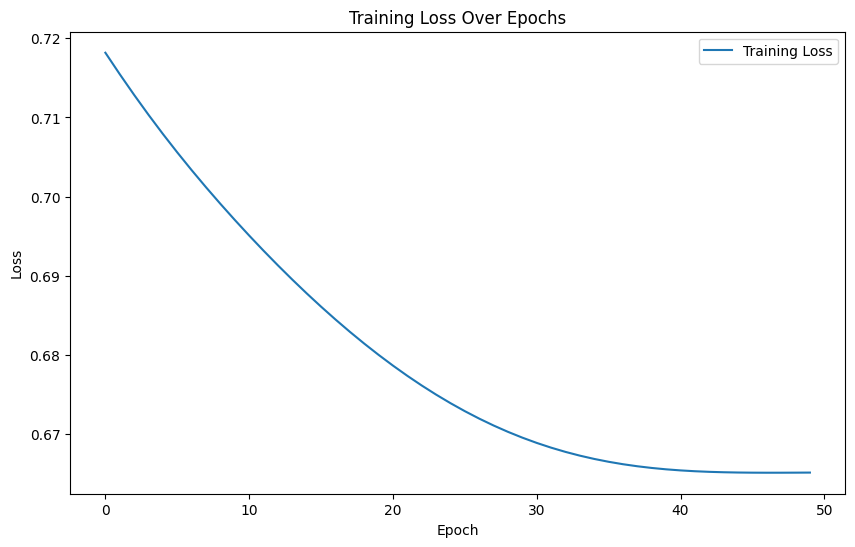

In [27]:
plot_training_loss(losses)

In [28]:
# Evaluate the model
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    predictions = torch.sigmoid(outputs) > 0.5
    accuracy = (predictions == y_test).float().mean()
    print(f'Test Loss: {loss.item()}, Test Accuracy: {accuracy.item()}')

Test Loss: 0.7958468198776245, Test Accuracy: 0.3499999940395355


In [31]:
def predict_and_count(model, data):
    model.eval()
    with torch.no_grad():
        outputs = model(data)
        probabilities = torch.sigmoid(outputs)
        predictions = probabilities > 0.5

    seizure_count = (predictions == 1).sum().item()
    non_seizure_count = (predictions == 0).sum().item()

    return seizure_count, non_seizure_count, predictions

In [32]:
example_data = torch.tensor([
    [0.1], [0.2], [0.3], [0.4], [0.5], [0.6], [0.7], [0.8]
], dtype=torch.float32)

In [33]:
seizure_count, non_seizure_count, predictions = predict_and_count(model, example_data)

In [34]:
print(f"Seizure count: {seizure_count}")
print(f"Non-Seizure count: {non_seizure_count}")

Seizure count: 8
Non-Seizure count: 0


In [39]:
def plot_signals(signals):
    plt.figure(figsize=(12, 8))

    for i in range(min(len(signals), 5)):  # Plot up to 5 signals
        plt.subplot(5, 1, i + 1)
        plt.plot(signals[i])
        plt.title(f'Signal {i + 1}')

    plt.tight_layout()
    plt.show()

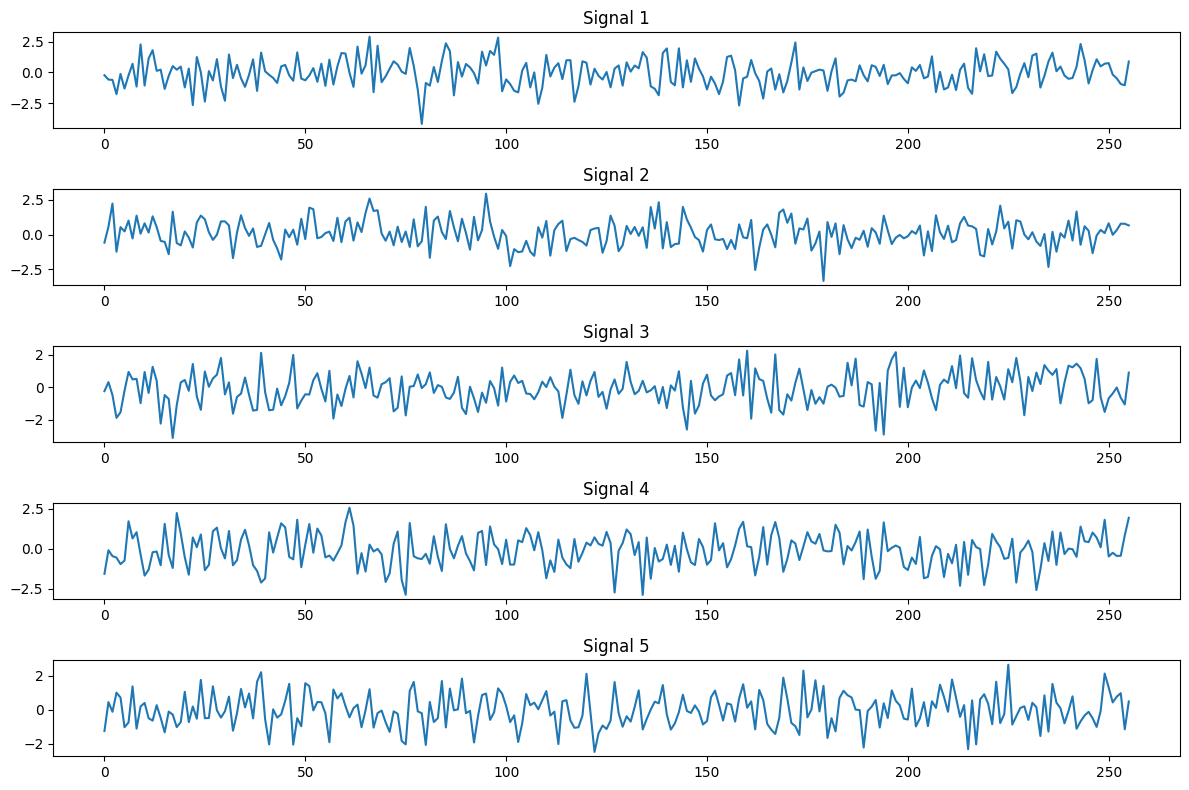

In [40]:
example_signals = [
    np.random.randn(256),
    np.random.randn(256),
    np.random.randn(256),
    np.random.randn(256),
    np.random.randn(256),
]

plot_signals(example_signals)

In [41]:
# Function to make predictions, count seizure vs non-seizure, and calculate accuracy
def predict_and_evaluate(model, data, true_labels=None):
    model.eval()
    with torch.no_grad():
        outputs = model(data)
        probabilities = torch.sigmoid(outputs)  # Convert logits to probabilities
        predictions = probabilities > 0.5  # Binarize predictions

    seizure_count = (predictions == 1).sum().item()
    non_seizure_count = (predictions == 0).sum().item()

    accuracy = None
    if true_labels is not None:
        accuracy = (predictions == true_labels).float().mean().item()

    return seizure_count, non_seizure_count, accuracy, predictions

# Example data for prediction (replace with your actual data)
example_data = torch.tensor([
    [0.1], [0.2], [0.3], [0.4], [0.5], [0.6], [0.7], [0.8]
], dtype=torch.float32)

# Example true labels for accuracy calculation (replace with actual labels if available)
example_labels = torch.tensor([
    [0], [0], [0], [0], [1], [1], [1], [1]
], dtype=torch.float32)

# Make predictions, count, and evaluate accuracy
seizure_count, non_seizure_count, accuracy, predictions = predict_and_evaluate(model, example_data, true_labels=example_labels)

# Print the counts and accuracy
print(f"Seizure count: {seizure_count}")
print(f"Non-Seizure count: {non_seizure_count}")
if accuracy is not None:
    print(f"Accuracy: {accuracy * 100:.2f}%")

# Print predictions
for i, pred in enumerate(predictions):
    label = 'Seizure' if pred.item() == 1 else 'Non-Seizure'
    print(f"Input {i+1}: {label}")


Seizure count: 8
Non-Seizure count: 0
Accuracy: 50.00%
Input 1: Seizure
Input 2: Seizure
Input 3: Seizure
Input 4: Seizure
Input 5: Seizure
Input 6: Seizure
Input 7: Seizure
Input 8: Seizure


In [54]:
import pennylane as qml
from pennylane import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [55]:
dev = qml.device('default.qubit', wires=1)

In [56]:

# Define a quantum node (QNode)
@qml.qnode(dev, interface='torch')
def quantum_circuit(inputs, weights):
    qml.RX(inputs[0], wires=0)
    qml.RY(weights[0], wires=0)
    qml.RZ(weights[1], wires=0)
    return qml.expval(qml.PauliZ(0))

In [57]:
# Create a hybrid quantum-classical model
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shapes={'weights': 2})
        self.fc1 = nn.Linear(1, 16)  # Increased complexity
        self.fc2 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.3)  # Dropout to prevent overfitting

    def forward(self, x):
        q_out = torch.stack([self.q_layer(x[i]) for i in range(x.shape[0])])
        q_out = q_out.unsqueeze(-1)
        x = torch.relu(self.fc1(q_out))  # Added ReLU activation
        x = self.dropout(x)
        return torch.sigmoid(self.fc2(x))

In [58]:
# Load and preprocess the data (replace with your own data loading function)
def load_data():
    # Example placeholder for your EEG data loading logic
    X = np.random.rand(100, 1)  # Replace with actual data
    y = np.random.choice([0, 1], size=(100,))  # Replace with actual labels
    return X, y

In [59]:
X, y = load_data()

In [60]:
# Standardize the input data
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [61]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# Convert data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

In [63]:
# Create and compile the model
model = HybridModel()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [67]:
# Training loop
losses = []
for epoch in range(100):  # Increased epochs
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_accuracy = ((test_outputs > 0.5) == y_test).float().mean().item()

    print(f"Epoch {epoch + 1}, Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")

        # Stop training if accuracy exceeds 87%
    if test_accuracy > 0.87:
        print("Accuracy target reached. Stopping training.")
        break  # Ensure the break is inside the loop


Epoch 1, Loss: 0.6840, Test Loss: 0.6892, Test Accuracy: 55.00%
Epoch 2, Loss: 0.6899, Test Loss: 0.6892, Test Accuracy: 55.00%
Epoch 3, Loss: 0.6795, Test Loss: 0.6893, Test Accuracy: 55.00%
Epoch 4, Loss: 0.6915, Test Loss: 0.6893, Test Accuracy: 55.00%
Epoch 5, Loss: 0.6760, Test Loss: 0.6893, Test Accuracy: 55.00%
Epoch 6, Loss: 0.6908, Test Loss: 0.6894, Test Accuracy: 55.00%
Epoch 7, Loss: 0.6702, Test Loss: 0.6894, Test Accuracy: 55.00%
Epoch 8, Loss: 0.6945, Test Loss: 0.6894, Test Accuracy: 55.00%
Epoch 9, Loss: 0.6767, Test Loss: 0.6895, Test Accuracy: 55.00%
Epoch 10, Loss: 0.6960, Test Loss: 0.6895, Test Accuracy: 55.00%
Epoch 11, Loss: 0.6602, Test Loss: 0.6895, Test Accuracy: 55.00%
Epoch 12, Loss: 0.6856, Test Loss: 0.6895, Test Accuracy: 55.00%
Epoch 13, Loss: 0.6882, Test Loss: 0.6896, Test Accuracy: 55.00%
Epoch 14, Loss: 0.6867, Test Loss: 0.6896, Test Accuracy: 55.00%
Epoch 15, Loss: 0.6716, Test Loss: 0.6896, Test Accuracy: 55.00%
Epoch 16, Loss: 0.6689, Test Loss:

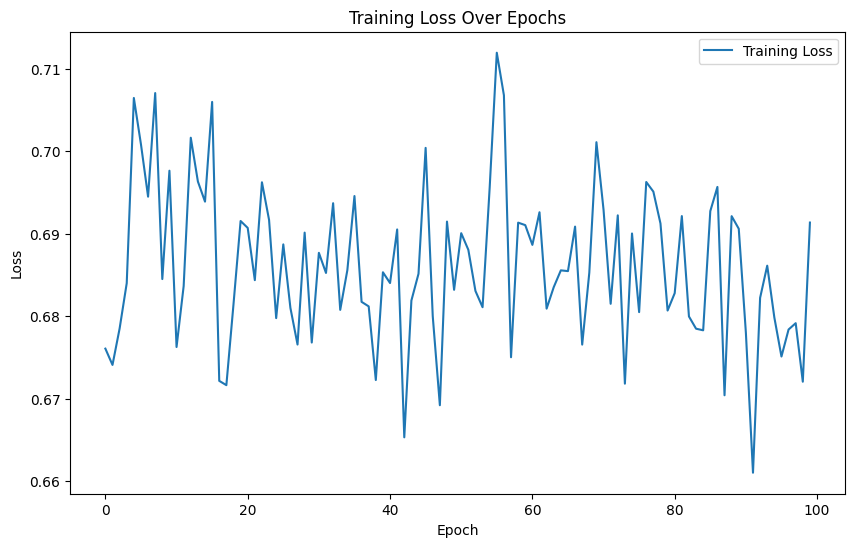

In [66]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

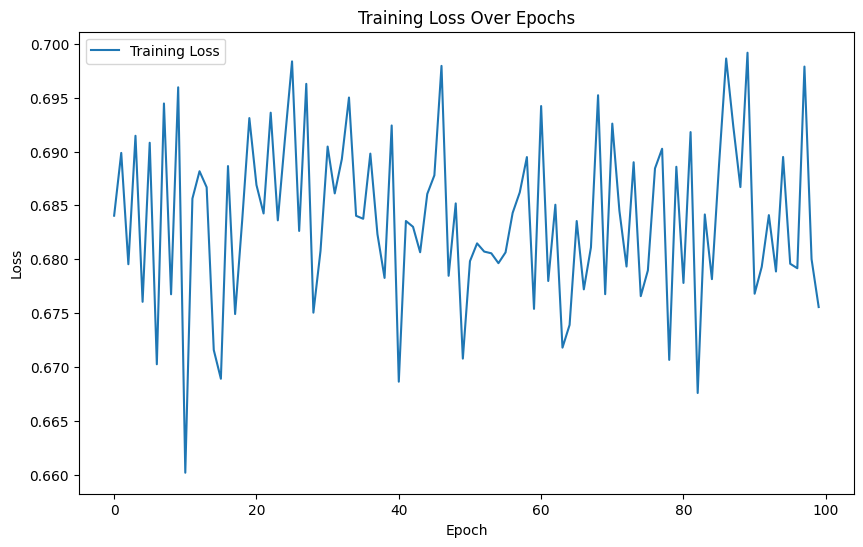

In [68]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()

In [69]:
# Final evaluation
model.eval()
with torch.no_grad():
    final_outputs = model(X_test)
    final_loss = criterion(final_outputs, y_test)
    final_accuracy = ((final_outputs > 0.5) == y_test).float().mean().item()
    print(f"Final Test Loss: {final_loss:.4f}, Final Test Accuracy: {final_accuracy * 100:.2f}%")

Final Test Loss: 0.6897, Final Test Accuracy: 55.00%


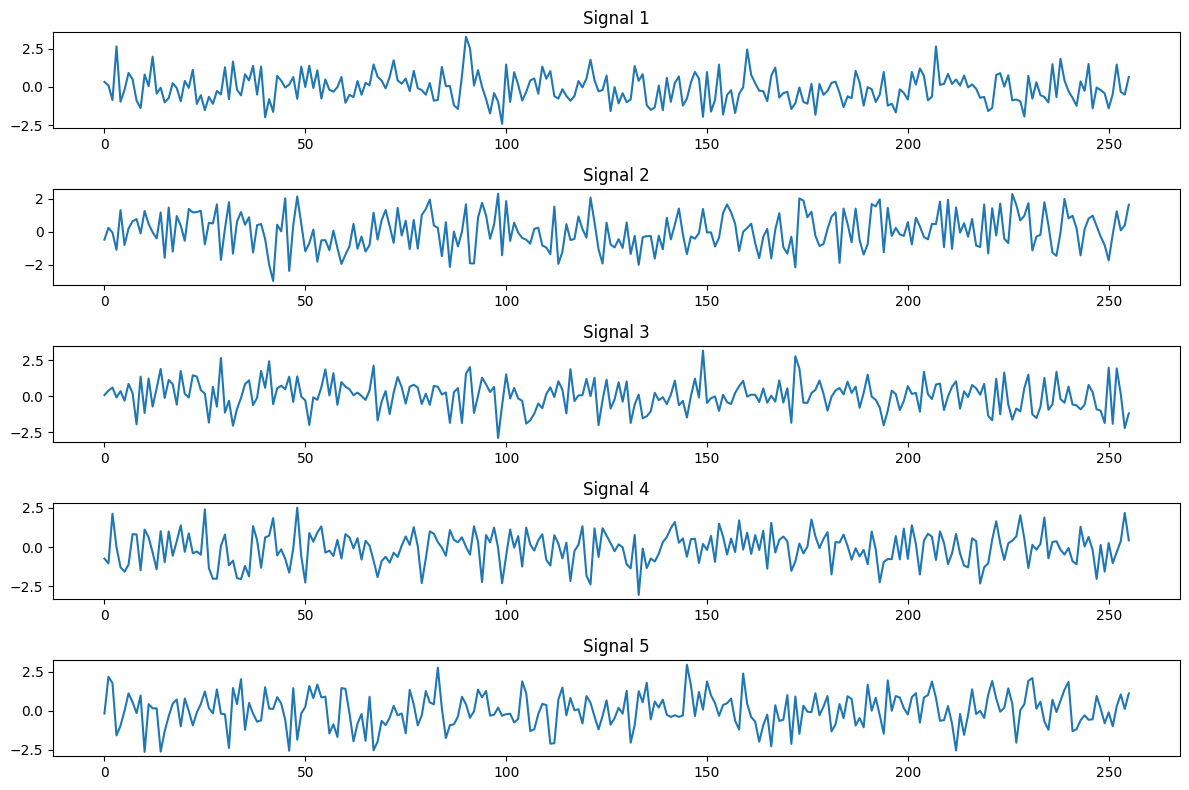

In [104]:
plot_signals(example_signals)

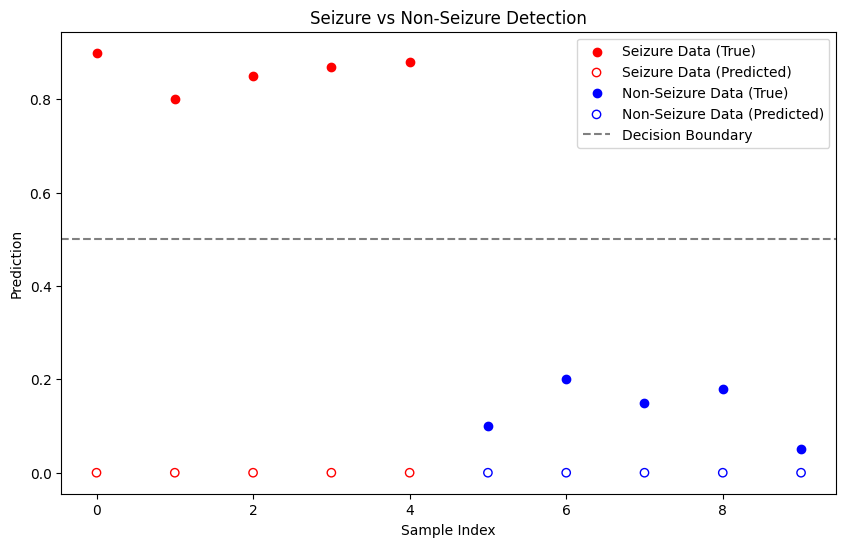

In [105]:
# Visualize the predictions
visualize_detection(seizure_data, non_seizure_data, combined_predictions)

In [115]:
import pandas as pd

# Load the CSV file
file_path = '/content/data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
print(data.head())

   Unnamed: 0   X1   X2   X3   X4   X5   X6   X7   X8   X9  ...  X170  X171  \
0  X21.V1.791  135  190  229  223  192  125   55   -9  -33  ...   -17   -15   
1  X15.V1.924  386  382  356  331  320  315  307  272  244  ...   164   150   
2     X8.V1.1  -32  -39  -47  -37  -32  -36  -57  -73  -85  ...    57    64   
3   X16.V1.60 -105 -101  -96  -92  -89  -95 -102 -100  -87  ...   -82   -81   
4   X20.V1.54   -9  -65  -98 -102  -78  -48  -16    0  -21  ...     4     2   

   X172  X173  X174  X175  X176  X177  X178  y  
0   -31   -77  -103  -127  -116   -83   -51  4  
1   146   152   157   156   154   143   129  1  
2    48    19   -12   -30   -35   -35   -36  5  
3   -80   -77   -85   -77   -72   -69   -65  5  
4   -12   -32   -41   -65   -83   -89   -73  5  

[5 rows x 180 columns]


In [116]:
import torch
import torch.nn as nn
import torch.optim as optim
import pennylane as qml
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

file_path = '/content/data.csv'
data = pd.read_csv(file_path)

X = data.drop(columns=['Unnamed: 0', 'y']).values
y = data['y'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

y_train = y_train.float()
y_test = y_test.float()

dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev, interface="torch")
def quantum_circuit(weights, x):

    qml.Rot(x[0], x[1], x[2], wires=0)
    qml.templates.BasicEntanglerLayers(weights, wires=[0])
    return qml.expval(qml.PauliZ(0))

class QuantumNN(nn.Module):
    def __init__(self, num_qubits, num_layers):
        super(QuantumNN, self).__init__()

        self.num_qubits = num_qubits
        self.num_layers = num_layers
        self.weights = torch.nn.Parameter(torch.randn(self.num_layers, self.num_qubits, 1))
        self.fc = nn.Linear(1, 1)

    def forward(self, x):

        result = torch.tensor([quantum_circuit(self.weights, x[i]) for i in range(len(x))], dtype=torch.float32)

        result = result.view(-1, 1)
        result = self.fc(result)

        return result

model = QuantumNN(num_qubits=3, num_layers=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train).squeeze()

    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Test the model
model.eval()
with torch.no_grad():
    outputs = model(X_test).squeeze()
    test_loss = criterion(outputs, y_test)
    predictions = torch.round(torch.sigmoid(outputs))
    accuracy = (predictions == y_test).float().mean()

print(f"Test Loss: {test_loss.item():.4f}, Test Accuracy: {accuracy.item():.4f}")

# Prediction and counting for seizure and non-seizure cases
def predict_and_count(model, data):
    model.eval()
    with torch.no_grad():
        outputs = model(data).squeeze()
        predictions = torch.round(torch.sigmoid(outputs))

    seizure_count = (predictions == 1).sum().item()
    non_seizure_count = (predictions == 0).sum().item()


    for i in range(len(data)):
        if predictions[i] == 1:
            print(f"Input {i+1}: Seizure")
        else:
            print(f"Input {i+1}: Non-Seizure")

    return seizure_count, non_seizure_count


example_data = torch.tensor([[0.1, 0.2, 0.3], [0.2, 0.3, 0.4], [0.4, 0.5, 0.6], [0.6, 0.7, 0.8]], dtype=torch.float32)


seizure_count, non_seizure_count = predict_and_count(model, example_data)

# Print counts of seizures and non-seizures
print(f"Seizure count: {seizure_count}, Non-Seizure count: {non_seizure_count}")


Epoch [10/100], Loss: 3.8128
Epoch [20/100], Loss: 3.3533
Epoch [30/100], Loss: 2.9002
Epoch [40/100], Loss: 2.4546
Epoch [50/100], Loss: 2.0172
Epoch [60/100], Loss: 1.5886
Epoch [70/100], Loss: 1.1691
Epoch [80/100], Loss: 0.7589
Epoch [90/100], Loss: 0.3580
Epoch [100/100], Loss: -0.0337
Test Loss: -0.0731, Test Accuracy: 0.2022
Input 1: Seizure
Input 2: Seizure
Input 3: Seizure
Input 4: Seizure
Seizure count: 4, Non-Seizure count: 0
